## Introduction

Lee is an incoming graduate student slated to study at Columbia University in New York. After securing his visa and plane tickets, he now has to decide where to rent an apartment for the duration of his stay. Fortunately, he is not constrained by price, as he and his family are well-off; however, he predicts that during his stay in New York, he will likely be unable to eat non-Korean food in a regular manner. That is, it is essential that he lives in a neighborhood with a) a number of Korean restaurants and b) Korean restaurants that have been given high ratings. Since he will be studying in Upper Manhattan, renting an apartment too far from Manhattan (Queens or Staten Island) is out of the question for Lee. The Bronx and Brooklyn (in addition to Manhattan) are options for Lee, since the 1, 2, and 3 MTA lines all cross these tree boroughs. In an attempt to inform his decision-making, Lee asks John to assist is looking for a neighborhood fitting Lee's requirements. Furthermore, he dreams of opening up his own Korean restaurant as a side gig; thus, he would like to know which borough among Manhattan, Bronx and Brooklyn has the least number of Korean restaurants.

## Business Question

1) Which neighborhood in Manhattan, the Bronx and Brooklyn has the highest concentration of Korean restaurants?

2) Which neighborhood in Manhattan, the Bronx and Brooklyn has has Korean restaurants with the highest average ratings?

3) Which neighborhood has the least number of Korean restaurants?


## Data

1) New York neighborhood data to be collected from https://cocl.us/new_york_dataset, and filtered to use only Manhattan, Brooklyn and Bronx areas

2) The number, location and ratings of Korean restaurants will be from FourSquare. After filtering for only Korean restaurants

- The two subsets of data will be merged to form one master dataset, of which will be the basis of ranking neighborhood based on Lee's requirements, as well as to visualize the resulting output for maximum impact


## Import libraries

In [64]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Dohun Na\anaconda3

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         861 KB

The following NEW packages will be INSTALLED:

  altair             conda-fo

## My Variables

In [65]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'AZNTZLGVGESFVXNLZLBTNA1CBY5BLBM5WGQEPHGJXC0BQKE2' # your Foursquare ID
CLIENT_SECRET = 'YQA1UY1PLMP4PLESPK0T4N5Z3OJJRJWERTBYTFC3EZUYBG3H' # your Foursquare Secret
VERSION = '20200717' # Foursquare API version

## Define crucial functions for geospatial data

In [66]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

## Filter initial NYC data for only Manhattan, Bronx and Brooklyn

In [67]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [68]:
ny_data.shape

(306, 4)

In [79]:
man_data = ny_data.drop(ny_data[ny_data['Borough'] != 'Manhattan'].index, axis=0)

In [80]:
bronx_data = ny_data.drop(ny_data[ny_data['Borough'] != 'Bronx'].index, axis=0)

In [84]:
brooklyn_data = ny_data.drop(ny_data[ny_data['Borough'] != 'Brooklyn'].index, axis=0)

In [87]:
master_data = man_data.append([bronx_data, brooklyn_data], ignore_index=True)

In [93]:
master_data.tail()

,Borough,Neighborhood,Latitude,Longitude
157,Brooklyn,Dumbo,40.703176,-73.988753
158,Brooklyn,Homecrest,40.598525,-73.959185
159,Brooklyn,Highland Park,40.681999,-73.890346
160,Brooklyn,Madison,40.609378,-73.948415
161,Brooklyn,Erasmus,40.646926,-73.948177


## Initial Data Analysis

In [95]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
korean_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in master_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    korean_restaurants=venues[venues['Category']=='Korean Restaurant']   
    print('(',count,'/',len(ny_data),')','Korean Restaurants in '+Neighborhood+', '+Borough+':'+str(len(korean_restaurants)))
    print(row)
    for resturant_detail in korean_restaurants.values.tolist():
        id, name , category=resturant_detail
        korean_rest_ny = korean_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Korean Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 2 / 306 ) Korean Restaurants in Chinatown, Manhattan:0
['Manhattan', 'Chinatown', 40.71561842231432, -73.99427936255978]
( 3 / 306 ) Korean Restaurants in Washington Heights, Manhattan:0
['Manhattan', 'Washington Heights', 40.85190252555305, -73.93690027985234]
( 4 / 306 ) Korean Restaurants in Inwood, Manhattan:0
['Manhattan', 'Inwood', 40.86768396449915, -73.92121042203897]
( 5 / 306 ) Korean Restaurants in Hamilton Heights, Manhattan:0
['Manhattan', 'Hamilton Heights', 40.823604284811935, -73.94968791883366]
( 6 / 306 ) Korean Restaurants in Manhattanville, Manhattan:0
['Manhattan', 'Manhattanville', 40.8169344294978, -73.9573853935188]
( 7 / 306 ) Korean Restaurants in Central Harlem, Manhattan:0
['Manhattan', 'Central Harlem', 40.81597606742414, -73.94321112603905]
( 8 / 306 ) Korean Restaurants in East Harlem, Manhattan:0
['Manhattan', 'East Harlem', 40

( 68 / 306 ) Korean Restaurants in Throgs Neck, Bronx:0
['Bronx', 'Throgs Neck', 40.81510925804005, -73.81635002158441]
( 69 / 306 ) Korean Restaurants in Country Club, Bronx:0
['Bronx', 'Country Club', 40.844245936947374, -73.8240992675385]
( 70 / 306 ) Korean Restaurants in Parkchester, Bronx:0
['Bronx', 'Parkchester', 40.837937822267286, -73.85600310535783]
( 71 / 306 ) Korean Restaurants in Westchester Square, Bronx:0
['Bronx', 'Westchester Square', 40.8406194964327, -73.84219407604444]
( 72 / 306 ) Korean Restaurants in Van Nest, Bronx:0
['Bronx', 'Van Nest', 40.84360847124718, -73.8662991807561]
( 73 / 306 ) Korean Restaurants in Morris Park, Bronx:0
['Bronx', 'Morris Park', 40.847549063536334, -73.85040178030421]
( 74 / 306 ) Korean Restaurants in Belmont, Bronx:0
['Bronx', 'Belmont', 40.85727710073895, -73.88845196134804]
( 75 / 306 ) Korean Restaurants in Spuyten Duyvil, Bronx:0
['Bronx', 'Spuyten Duyvil', 40.88139497727086, -73.91719048210393]
( 76 / 306 ) Korean Restaurants 

( 134 / 306 ) Korean Restaurants in Boerum Hill, Brooklyn:0
['Brooklyn', 'Boerum Hill', 40.685682912091444, -73.98374824115798]
( 135 / 306 ) Korean Restaurants in Prospect Lefferts Gardens, Brooklyn:0
['Brooklyn', 'Prospect Lefferts Gardens', 40.658420017469815, -73.95489867077713]
( 136 / 306 ) Korean Restaurants in Ocean Hill, Brooklyn:0
['Brooklyn', 'Ocean Hill', 40.678402554795355, -73.91306831787395]
( 137 / 306 ) Korean Restaurants in City Line, Brooklyn:0
['Brooklyn', 'City Line', 40.67856995727479, -73.86797598081334]
( 138 / 306 ) Korean Restaurants in Bergen Beach, Brooklyn:0
['Brooklyn', 'Bergen Beach', 40.61514955045308, -73.89855633630317]
( 139 / 306 ) Korean Restaurants in Midwood, Brooklyn:0
['Brooklyn', 'Midwood', 40.62559589869843, -73.95759523489838]
( 140 / 306 ) Korean Restaurants in Prospect Park South, Brooklyn:0
['Brooklyn', 'Prospect Park South', 40.647008603185185, -73.96261316716048]
( 141 / 306 ) Korean Restaurants in Georgetown, Brooklyn:0
['Brooklyn', 'Ge

In [96]:
korean_rest_ny.to_csv('korean_rest_ny_csv.csv')

In [97]:
korean_ny = pd.read_csv('korean_rest_ny_csv.csv')
korean_rest_ny.tail()

,Borough,Neighborhood,ID,Name
22,Brooklyn,Williamsburg,52bf3053498e754b09a440b5,Dotory
23,Brooklyn,North Side,43db5698f964a5208a2e1fe3,Dokebi
24,Brooklyn,North Side,59c295349b04732c1d51aa52,Kimbap Lab
25,Brooklyn,South Side,52bf3053498e754b09a440b5,Dotory
26,Brooklyn,Fort Hamilton,4b240e1af964a5200a6024e3,Kimchee Korean Cuisine


In [98]:
korean_rest_ny.shape

(27, 4)

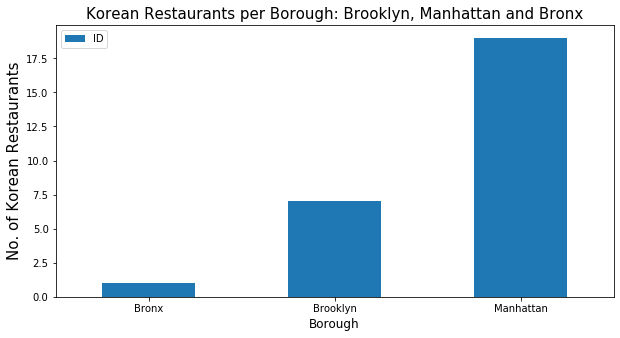

In [127]:
korean_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5))
plt.title('Korean Restaurants per Borough: Brooklyn, Manhattan and Bronx', fontsize = 15)
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('No. of Korean Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

As expected, Manhattan had the highest number of Korean restaurants

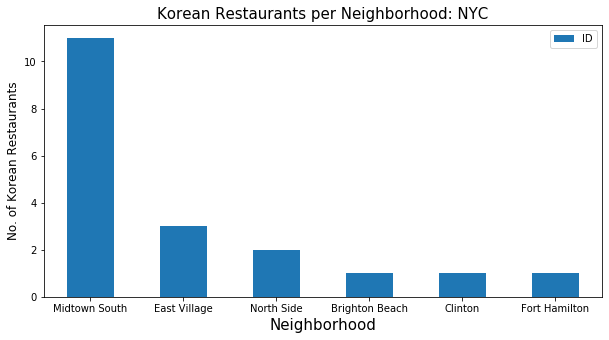

In [123]:
NOofNeigh = 6 # top number for graphing all the same past 6
korean_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5))
plt.title('Korean Restaurants per Neighborhood: NYC', fontsize = 15)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Korean Restaurants', fontsize=12)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

By neighborhood among the three boroughs, Midtown South had the highest number of Korean restaurants

## Get ranking of each restaurant for analysis

In [103]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
korean_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in korean_rest_ny.valu es.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(korean_rest_ny),')','processed')
    korean_rest_stats_ny = korean_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
korean_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5f1239b58899163a7b2d6aa2'}, 'response': {'venue': {'id': '5dbcafa6e40280000819d3db', 'name': 'Kochi', 'contact': {}, 'location': {'address': '652 10th Ave', 'crossStreet': '46th Street', 'lat': 40.76203, 'lng': -73.99355, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76203, 'lng': -73.99355}], 'postalCode': '10036', 'cc': 'US', 'neighborhood': "Hell's Kitchen", 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['652 10th Ave (46th Street)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kochi/5dbcafa6e40280000819d3db', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'url': 'http://kochinyc.com', 'price': {'tier': 2, 'message': 'Moderat

{'meta': {'code': 200, 'requestId': '5f123bec58d9ca05f7426fc8'}, 'response': {'venue': {'id': '5dec54b8f93ca90007806f97', 'name': 'Mokyo', 'contact': {}, 'location': {'address': '109 Saint Marks Pl', 'lat': 40.727179, 'lng': -73.984056, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727179, 'lng': -73.984056}, {'label': 'entrance', 'lat': 40.727122, 'lng': -73.983949}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['109 Saint Marks Pl', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mokyo/5dec54b8f93ca90007806f97', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {

{'meta': {'code': 200, 'requestId': '5f1239a15d15c80dc77a394a'}, 'response': {'venue': {'id': '54cd73be498e9ab78644ab32', 'name': 'Oiji', 'contact': {'phone': '6467679050', 'formattedPhone': '(646) 767-9050', 'instagram': 'oijinyc'}, 'location': {'address': '119 1st Ave', 'lat': 40.727168125595306, 'lng': -73.98564524259254, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727168125595306, 'lng': -73.98564524259254}, {'label': 'entrance', 'lat': 40.727239, 'lng': -73.985773}], 'postalCode': '10003', 'cc': 'US', 'neighborhood': 'East Village', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119 1st Ave', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/oiji/54cd73be498e9ab78644ab32', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5f123b62d2cc4036204a3c86'}, 'response': {'venue': {'id': '4e67f1c7d16433b90090c8f3', 'name': 'Jungsik', 'contact': {'phone': '2122190900', 'formattedPhone': '(212) 219-0900', 'twitter': 'jungsikdang'}, 'location': {'address': '2 Harrison St', 'crossStreet': 'at Hudson St.', 'lat': 40.718694630954566, 'lng': -74.00906972656956, 'labeledLatLngs': [{'label': 'display', 'lat': 40.718694630954566, 'lng': -74.00906972656956}, {'label': 'entrance', 'lat': 40.718744, 'lng': -74.009072}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2 Harrison St (at Hudson St.)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jungsik/4e67f1c7d16433b90090c8f3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean

{'meta': {'code': 200, 'requestId': '5f123960bea21c0c7bac15ff'}, 'response': {'venue': {'id': '59aa0677e17910245d942204', 'name': 'Jeju Noodle Bar', 'contact': {'phone': '2019213333', 'formattedPhone': '(201) 921-3333', 'instagram': 'jejunoodlebar'}, 'location': {'address': '679 Greenwich St', 'crossStreet': 'at Christopher St', 'lat': 40.73294539559912, 'lng': -74.0073655954149, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73294539559912, 'lng': -74.0073655954149}, {'label': 'entrance', 'lat': 40.733036, 'lng': -74.007344}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['679 Greenwich St (at Christopher St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jeju-noodle-bar/59aa0677e17910245d942204', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '5f123c005de8cc2b2118ab37'}, 'response': {'venue': {'id': '56a14149498e9983c0199038', 'name': 'Mokja', 'contact': {'phone': '6469644296', 'formattedPhone': '(646) 964-4296'}, 'location': {'address': '852 Amsterdam Ave', 'crossStreet': '1010st', 'lat': 40.797706635429854, 'lng': -73.9677888515501, 'labeledLatLngs': [{'label': 'display', 'lat': 40.797706635429854, 'lng': -73.9677888515501}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['852 Amsterdam Ave (1010st)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mokja/56a14149498e9983c0199038', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'

{'meta': {'code': 200, 'requestId': '5f123bc00af06e78b9b77972'}, 'response': {'venue': {'id': '540f86da498e020149fa7676', 'name': 'Jongro BBQ', 'contact': {'phone': '2124732233', 'formattedPhone': '(212) 473-2233', 'facebook': '409586342513959', 'facebookUsername': 'jongrobbqny', 'facebookName': 'Jongro BBQ'}, 'location': {'address': '22 W 32nd St Fl 2', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.747574, 'lng': -73.987043, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747574, 'lng': -73.987043}], 'postalCode': '10001', 'cc': 'US', 'neighborhood': 'Koreatown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['22 W 32nd St Fl 2 (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jongro-bbq/540f86da498e020149fa7676', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3

                         ID               Name  Likes  Rating  Tips
0  5aab0d2ae179107b87768ff8  Samwon Garden BBQ     81     8.7    16
( 9 / 27 ) processed
{'meta': {'code': 200, 'requestId': '5f123b7002abd05a5943f7d0'}, 'response': {'venue': {'id': '4a9d3c1af964a520ff3720e3', 'name': 'E-Mo Kimbap', 'contact': {'phone': '2125941466', 'formattedPhone': '(212) 594-1466'}, 'location': {'address': '2 W 32nd St', 'crossStreet': 'btwn 5th Ave & Broadway', 'lat': 40.747264, 'lng': -73.986221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747264, 'lng': -73.986221}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2 W 32nd St (btwn 5th Ave & Broadway)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/emo-kimbap/4a9d3c1af964a520ff3720e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'

0  4a9d3c1af964a520ff3720e3  E-Mo Kimbap    109     8.8    42
( 10 / 27 ) processed
{'meta': {'code': 200, 'requestId': '5f123bd1ecd0e51386684369'}, 'response': {'venue': {'id': '49becfd3f964a520e0541fe3', 'name': 'Woorijip', 'contact': {'phone': '2122441115', 'formattedPhone': '(212) 244-1115'}, 'location': {'address': '12 W 32nd St', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.7476231963955, 'lng': -73.98637205431945, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7476231963955, 'lng': -73.98637205431945}], 'postalCode': '10001', 'cc': 'US', 'neighborhood': 'Ktown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['12 W 32nd St (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/woorijip/49becfd3f964a520e0541fe3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3

{'meta': {'code': 200, 'requestId': '5f123a1464f56678cedec36e'}, 'response': {'venue': {'id': '4a1dd896f964a520a27b1fe3', 'name': 'Cho Dang Gol', 'contact': {'phone': '2126958222', 'formattedPhone': '(212) 695-8222', 'instagram': 'chodanggol', 'facebook': '115988201756815', 'facebookUsername': 'ChoDangGol', 'facebookName': 'Cho Dang Gol'}, 'location': {'address': '55 W 35th St', 'crossStreet': 'btwn 5th & 6th Ave', 'lat': 40.750158472609044, 'lng': -73.986438204421, 'labeledLatLngs': [{'label': 'display', 'lat': 40.750158472609044, 'lng': -73.986438204421}, {'label': 'entrance', 'lat': 40.750145, 'lng': -73.98633}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['55 W 35th St (btwn 5th & 6th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cho-dang-gol/4a1dd896f964a520a27b1fe3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Kor

{'meta': {'code': 200, 'requestId': '5f123b5e44d64a5afbeb0173'}, 'response': {'venue': {'id': '49f47acdf964a5200b6b1fe3', 'name': 'Pocha 32', 'contact': {'phone': '2122791876', 'formattedPhone': '(212) 279-1876'}, 'location': {'address': '15 W 32nd St', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.747634864616465, 'lng': -73.98648664038662, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747634864616465, 'lng': -73.98648664038662}, {'label': 'entrance', 'lat': 40.747643, 'lng': -73.986431}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['15 W 32nd St (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pocha-32/49f47acdf964a5200b6b1fe3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 's

{'meta': {'code': 200, 'requestId': '5f123a1464f56678cedec537'}, 'response': {'venue': {'id': '517563f9498e0a4859d08fe4', 'name': 'BCD Tofu House', 'contact': {'phone': '2129671900', 'formattedPhone': '(212) 967-1900', 'twitter': 'bcdtofuhouse'}, 'location': {'address': '5 W 32nd St', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.747362, 'lng': -73.985663, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747362, 'lng': -73.985663}, {'label': 'entrance', 'lat': 40.747481, 'lng': -73.986046}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5 W 32nd St (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bcd-tofu-house/517563f9498e0a4859d08fe4', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_',

{'meta': {'code': 200, 'requestId': '5f123bb5af2b4b3137f4abd4'}, 'response': {'venue': {'id': '547d03e3498eb32c879589da', 'name': 'Baekjeong NYC (Kang Ho Dong Baekjeong)', 'contact': {'phone': '2129669839', 'formattedPhone': '(212) 966-9839', 'twitter': 'baekjeongnyc', 'instagram': 'baekjeongnyc', 'facebook': '425961227537735', 'facebookUsername': 'baekjeongnyc', 'facebookName': 'Kang Ho Dong Baekjeong - Koreatown NYC'}, 'location': {'address': '1 E 32nd St', 'crossStreet': 'at 5th Ave', 'lat': 40.74709879834891, 'lng': -73.98519423416221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74709879834891, 'lng': -73.98519423416221}, {'label': 'entrance', 'lat': 40.747063, 'lng': -73.985067}], 'postalCode': '10016', 'cc': 'US', 'neighborhood': 'Koreatown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1 E 32nd St (at 5th Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/baekjeong-nyc/547d03e3498eb32c879589da',

( 16 / 27 ) processed
{'meta': {'code': 200, 'requestId': '5f123c20bd9c5b4d005aef84'}, 'response': {'venue': {'id': '5b857af5b77c77002c2fb242', 'name': 'Hortus', 'contact': {'phone': '6468583784', 'formattedPhone': '(646) 858-3784'}, 'location': {'address': '271 5th Ave', 'crossStreet': 'b/t 30th St & 29th St', 'lat': 40.74551921832626, 'lng': -73.98658183981865, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74551921832626, 'lng': -73.98658183981865}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['271 5th Ave (b/t 30th St & 29th St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hortus/5b857af5b77c77002c2fb242', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': Fa

                         ID                 Name  Likes  Rating  Tips
0  5aa9bc3b1f8ed6636dbb7fa5  Yoon Haeundae Galbi     55     7.9     6
( 18 / 27 ) processed
{'meta': {'code': 200, 'requestId': '5f123bf3b2f69d1e8baea7a7'}, 'response': {'venue': {'id': '527a94ad11d27fb66eee267a', 'name': 'BarKogi Korean Restaurant & Bar', 'contact': {'phone': '2123088810', 'formattedPhone': '(212) 308-8810', 'twitter': 'barkogi', 'facebook': '1404409586459892', 'facebookUsername': 'BarKogi', 'facebookName': 'BarKogi'}, 'location': {'address': '957 2nd Ave', 'crossStreet': 'at E 51st St', 'lat': 40.75538916703279, 'lng': -73.96823554323909, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75538916703279, 'lng': -73.96823554323909}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['957 2nd Ave (at E 51st St)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/barkogi', 'categories': [{'id': '4bf58dd8

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4be747b7bcef2d7fdb1b06e5
( 20 / 27 ) processed
{'meta': {'code': 200, 'requestId': '5f123bdf8b53332abdcb6725'}, 'response': {'venue': {'id': '4c9d5c0303133704a96f5ed5', 'name': 'Cafe At Your Mother-in-Law', 'contact': {'phone': '7189424088', 'formattedPhone': '(718) 942-4088', 'twitter': 'cafeaymil_ny'}, 'location': {'address': '3071 Brighton 4th St', 'lat': 40.57757524231774, 'lng': -73.96344895612154, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57757524231774, 'lng': -73.96344895612154}, {'label': 'entrance', 'lat': 40.577515, 'lng': -73.963289}], 'postalCode': '11235', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3071 Brighton 4th St', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-at-your-motherinlaw/4c9d5c0303133704a96f5ed5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean R

{'meta': {'code': 200, 'requestId': '5f123c9ea536c57dc6dd9c6b'}, 'response': {'venue': {'id': '4fa162e0e4b0badc81404a51', 'name': 'Kimchi Grill', 'contact': {'phone': '7183601839', 'formattedPhone': '(718) 360-1839'}, 'location': {'address': '766 Washington Ave', 'crossStreet': 'btwn Sterling & Park Pl.', 'lat': 40.67512957407338, 'lng': -73.96324476804656, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67512957407338, 'lng': -73.96324476804656}], 'postalCode': '11238', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['766 Washington Ave (btwn Sterling & Park Pl.)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kimchi-grill/4fa162e0e4b0badc81404a51', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5f123bc7f5887b5051dbca51'}, 'response': {'venue': {'id': '52bf3053498e754b09a440b5', 'name': 'Dotory', 'contact': {'phone': '7185991399', 'formattedPhone': '(718) 599-1399', 'facebook': '474808822615656', 'facebookUsername': 'dotorybk', 'facebookName': 'Dotory'}, 'location': {'address': '353 Broadway', 'lat': 40.707729602666035, 'lng': -73.95577850789788, 'labeledLatLngs': [{'label': 'display', 'lat': 40.707729602666035, 'lng': -73.95577850789788}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['353 Broadway', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dotory/52bf3053498e754b09a440b5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '5f123ce567666079e5116448'}, 'response': {'venue': {'id': '43db5698f964a5208a2e1fe3', 'name': 'Dokebi', 'contact': {'phone': '7187821424', 'formattedPhone': '(718) 782-1424', 'twitter': 'dokebibbq'}, 'location': {'address': '199 Grand St', 'crossStreet': 'btwn Bedford & Driggs Ave.', 'lat': 40.714185631114006, 'lng': -73.96033203612464, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714185631114006, 'lng': -73.96033203612464}, {'label': 'entrance', 'lat': 40.714198, 'lng': -73.960309}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['199 Grand St (btwn Bedford & Driggs Ave.)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dokebi/43db5698f964a5208a2e1fe3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categ

{'meta': {'code': 200, 'requestId': '5f123965bea21c0c7bac245e'}, 'response': {'venue': {'id': '59c295349b04732c1d51aa52', 'name': 'Kimbap Lab', 'contact': {'phone': '7187342321', 'formattedPhone': '(718) 734-2321'}, 'location': {'address': '238 Bedford Avenue', 'lat': 40.71616, 'lng': -73.95953, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71616, 'lng': -73.95953}], 'postalCode': '11249', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['238 Bedford Avenue', 'Brooklyn, NY 11249', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kimbap-lab/59c295349b04732c1d51aa52', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '56aa371be4b08b9a8d57350b', 'name': 'Food Stand', 'pluralName': 'Food Stands', 'shortName': 'Food Stand', 'i

{'meta': {'code': 200, 'requestId': '5f123aeb40a5a7407631a60a'}, 'response': {'venue': {'id': '52bf3053498e754b09a440b5', 'name': 'Dotory', 'contact': {'phone': '7185991399', 'formattedPhone': '(718) 599-1399', 'facebook': '474808822615656', 'facebookUsername': 'dotorybk', 'facebookName': 'Dotory'}, 'location': {'address': '353 Broadway', 'lat': 40.707729602666035, 'lng': -73.95577850789788, 'labeledLatLngs': [{'label': 'display', 'lat': 40.707729602666035, 'lng': -73.95577850789788}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['353 Broadway', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dotory/52bf3053498e754b09a440b5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '5f123b5c0b11231648c839b3'}, 'response': {'venue': {'id': '4b240e1af964a5200a6024e3', 'name': 'Kimchee Korean Cuisine', 'contact': {'phone': '7185675741', 'formattedPhone': '(718) 567-5741'}, 'location': {'address': '9324 3rd Ave', 'crossStreet': 'at 94th St', 'lat': 40.61797065682916, 'lng': -74.03344650023448, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61797065682916, 'lng': -74.03344650023448}, {'label': 'entrance', 'lat': 40.618097, 'lng': -74.033403}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9324 3rd Ave (at 94th St)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kimchee-korean-cuisine/4b240e1af964a5200a6024e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 's

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
22,Brooklyn,Williamsburg,52bf3053498e754b09a440b5,Dotory,139,8.4,44
23,Brooklyn,North Side,43db5698f964a5208a2e1fe3,Dokebi,292,8.1,101
24,Brooklyn,North Side,59c295349b04732c1d51aa52,Kimbap Lab,7,8.1,0
25,Brooklyn,South Side,52bf3053498e754b09a440b5,Dotory,139,8.4,44
26,Brooklyn,Fort Hamilton,4b240e1af964a5200a6024e3,Kimchee Korean Cuisine,17,6.4,12


In [105]:
korean_rest_stats_ny.shape

(27, 7)

In [106]:
korean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       27 non-null     object 
 1   Neighborhood  27 non-null     object 
 2   ID            27 non-null     object 
 3   Name          27 non-null     object 
 4   Likes         27 non-null     object 
 5   Rating        27 non-null     float64
 6   Tips          27 non-null     object 
dtypes: float64(1), object(6)
memory usage: 1.6+ KB


In [107]:
korean_rest_stats_ny['Likes'] = korean_rest_stats_ny['Likes'].astype('float64')
korean_rest_stats_ny['Tips'] = korean_rest_stats_ny['Tips'].astype('float64')
korean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       27 non-null     object 
 1   Neighborhood  27 non-null     object 
 2   ID            27 non-null     object 
 3   Name          27 non-null     object 
 4   Likes         27 non-null     float64
 5   Rating        27 non-null     float64
 6   Tips          27 non-null     float64
dtypes: float64(3), object(4)
memory usage: 1.6+ KB


In [112]:
korean_rest_stats_ny.describe()

,Likes,Rating,Tips
count,27.000000,27.000000,27.000000
mean,261.185185,7.988889,68.407407
std,330.770666,1.695091,74.320128
min,0.000000,0.000000,0.000000
25%,27.000000,8.100000,7.500000
50%,139.000000,8.400000,44.000000
75%,309.000000,8.600000,104.500000
max,1228.000000,9.000000,284.000000


In [111]:
# Resturant with maximum Ratings
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              578bec6c498e3150fc369f3b
Name                    Thursday Kitchen
Likes                                287
Rating                                 9
Tips                                  73
Name: 1, dtype: object

## Identify and visualize neighborhood with maximum average ratings

In [113]:
ny_neighborhood_stats=korean_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
10,Tribeca,8.900000
2,East Village,8.800000
8,Prospect Heights,8.500000
6,Midtown South,8.463636
9,South Side,8.400000
13,Williamsburg,8.400000
1,Clinton,8.300000
12,West Village,8.300000
5,Manhattan Valley,8.100000
7,North Side,8.100000


### Surprisingly, the neighborhood with the top average ratings is not in Midtown South, which is the location of Manhattan's K-town; in fact, that distinction goes to Tribeca

In [114]:
ny_borough_stats=korean_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.447368
1,Brooklyn,7.885714
0,Bronx,0.000000


As expected, by borough Manhattan has the highest average, while it seems the ratings for the Bronx are not available (despite having a restaurant there)

## Visualization

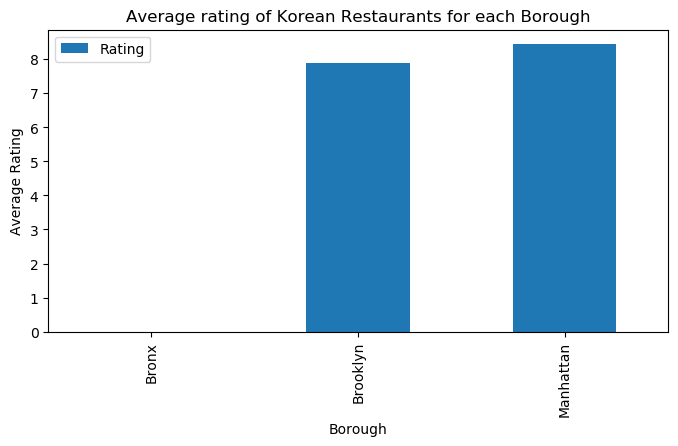

In [126]:
plt.figure(figsize=(8,4), dpi = 100)
plt.title('Average rating of Korean Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 10)
plt.ylabel('Average Rating', fontsize=10)
korean_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

We will merge the restaurant dataset with the NYC data for location purposes

In [118]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Brighton Beach,40.576825,-73.965094,7.300000
1,Manhattan,Clinton,40.759101,-73.996119,8.300000
2,Manhattan,East Village,40.727847,-73.982226,8.800000
3,Brooklyn,Fort Hamilton,40.614768,-74.031979,6.400000
4,Bronx,Kingsbridge Heights,40.870392,-73.901523,0.000000
5,Manhattan,Manhattan Valley,40.797307,-73.964286,8.100000
6,Manhattan,Midtown South,40.748510,-73.988713,8.463636
7,Brooklyn,North Side,40.714823,-73.958809,8.100000
8,Brooklyn,Prospect Heights,40.676822,-73.964859,8.500000
9,Brooklyn,South Side,40.710861,-73.958001,8.400000


In [119]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [120]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Conclusion
The dominance of Midtown South (K-town) was apparent in the number of Korean restaurants per neighborhood. However, the exercise unexpectedly showed that, according to FourSquare users, the highest rated restaurants were not in fact in Midtown South, but in Lower Manhattan. Overall, our analysis has provided Lee (and other Koreans contemplating where to rent apartments in NYC) abundant data in this respect, which will inform his decision-making